# Chapter 5 — Integrated Example and Model Evaluation (Code Companion)

This notebook collects the executable code from Chapter 5 and demonstrates a complete end-to-end biomedical data analysis workflow, from data generation to model evaluation.

## Clinical Question, Hypotheses, and Data Collection

This section provides executable examples illustrating the concepts discussed in the text, with emphasis on interpretation and best practices for biomedical data.

### Data Collection

We begin by loading and inspecting the dataset that will be reused across the analyses.

In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(42)

N = 104
arm = rng.choice(["drug", "placebo"], size=N)
age = rng.normal(56, 12, N).clip(18, 85)
sex = rng.choice(["F","M"], size=N, p=[0.7,0.3])
BMI = rng.normal(27, 5, N).clip(17, 45)

# Baseline biomarkers (right-skewed)
il6_0  = np.exp(rng.normal(3.3, 0.5, N))
crp_0  = np.exp(rng.normal(2.0, 0.6, N))
il1b_0 = np.exp(rng.normal(2.1, 0.4, N))
tnf_0  = np.exp(rng.normal(2.5, 0.4, N))

# Treatment effect on IL-6 at Week 12
base_drop_il6 = rng.normal(-3, 6, N)
extra_drop = np.where(arm=="drug", rng.normal(-10, 6, N), 0)
il6_12 = np.maximum(0.1, il6_0 + base_drop_il6 + extra_drop)

# Other biomarkers covary with IL-6
crp_12  = np.maximum(0.05, crp_0  + 0.03*(il6_12 - il6_0)  + rng.normal(0,1.5,N))
il1b_12 = np.maximum(0.05, il1b_0 + 0.02*(il6_12 - il6_0) + rng.normal(0,1.0,N))
tnf_12  = np.maximum(0.05, tnf_0  + 0.015*(il6_12 - il6_0)+ rng.normal(0,1.0,N))

# DAS28 improvement linked to cytokine drop
D0 = rng.normal(5.6, 0.8, N)
D12 = (D0 - 0.03*(il6_0 - il6_12) - 0.01*(crp_0 - crp_12)
       + np.where(arm=="drug", -1.2, -0.2) + rng.normal(0,0.3,N))

# Responder definition
responder = (((D0 - D12) >= 1.2) | (il6_0 > np.median(il6_0))).astype(int)

df = pd.DataFrame(dict(arm=arm, age=age, sex=sex, BMI=BMI,
    il6_0=il6_0, il6_12=il6_12, crp_0=crp_0, crp_12=crp_12,
    il1b_0=il1b_0, il1b_12=il1b_12, tnf_0=tnf_0, tnf_12=tnf_12,
    das28_0=D0, das28_12=D12, responder=responder))

## Data Analysis

This section provides executable examples illustrating the concepts discussed in the text, with emphasis on interpretation and best practices for biomedical data.

### Exploratory Data Analysis

We begin by loading and inspecting the dataset that will be reused across the analyses.

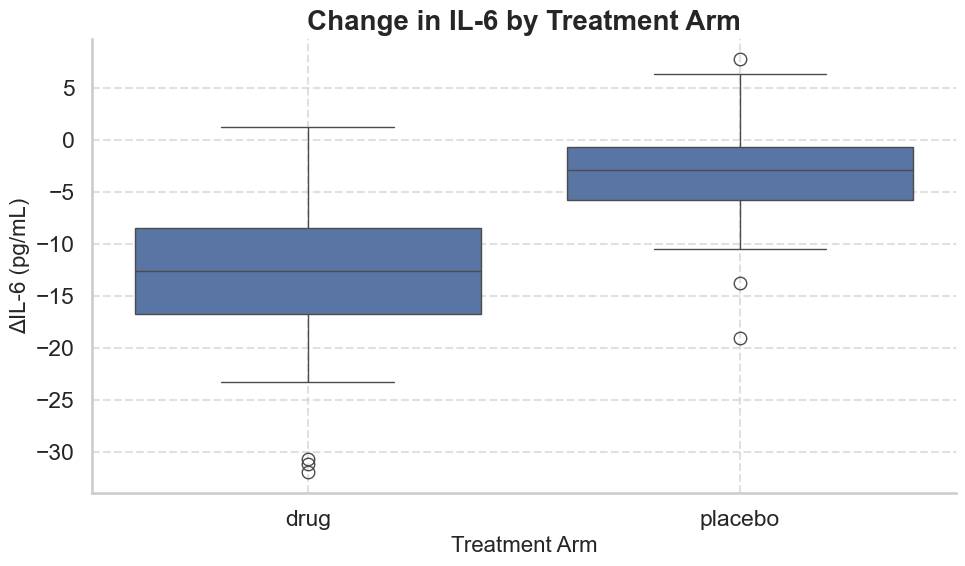

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set publication-style aesthetics
sns.set_theme(style="whitegrid", context="talk")

colours = sns.color_palette("dark", n_colors=3) 

# Create the figure
plt.figure(figsize=(10, 6))

# Boxplot of IL-6 changes
sns.boxplot(x='arm', y=df['il6_12'] - df['il6_0'], data=df)

# Add title, labels, and grid
plt.xlabel('Treatment Arm', fontsize=16) 
plt.ylabel('ΔIL-6 (pg/mL)', fontsize=16)
plt.title('Change in IL-6 by Treatment Arm', fontsize=20, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

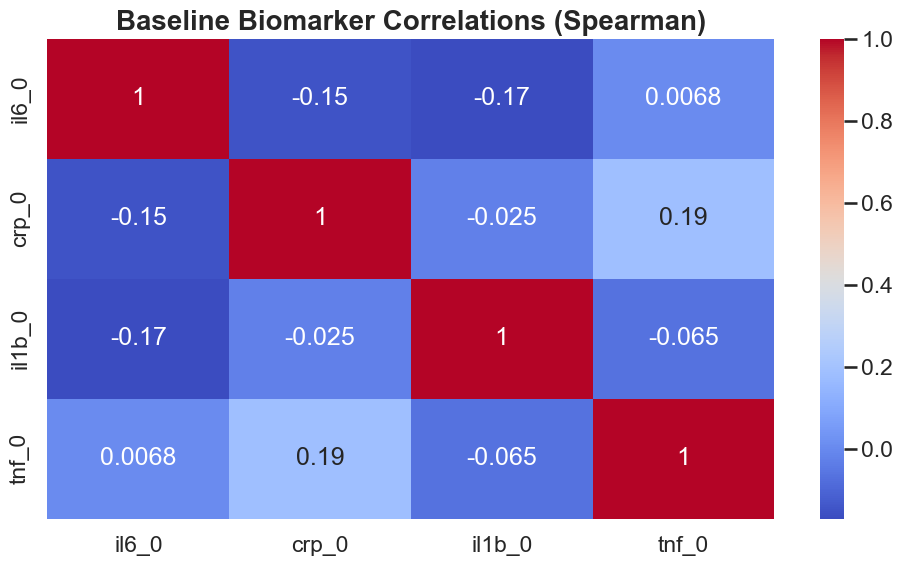

In [3]:
corr = df[['il6_0', 'crp_0', 'il1b_0', 'tnf_0']].corr(method='spearman')

# Create the figure
plt.figure(figsize=(10, 6))

sns.heatmap(corr, annot=True, cmap=sns.color_palette("coolwarm", as_cmap=True))

# Add title and grid
plt.title('Baseline Biomarker Correlations (Spearman)', fontsize=20, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

### Hypothesis Testing and Effect Sizes

In the following cell, we demonstrate the method with a minimal, runnable example.

In [4]:
from scipy import stats

# Calculate ΔIL-6 per participant
D_il6 = df['il6_12'] - df['il6_0']
D_il6_drug = D_il6[df.arm=="drug"]
D_il6_placebo = D_il6[df.arm=="placebo"]

# Perform t-test between arms
t, p = stats.ttest_ind(D_il6_drug, D_il6_placebo, equal_var=False)
mean_diff = D_il6_drug.mean() - D_il6_placebo.mean()
print("Mean difference:", mean_diff)
print("p-value:", p)

Mean difference: -9.879682832010582
p-value: 6.938650565770681e-11


In [5]:
import pandas as pd

# Contingency table
ct = pd.crosstab(df.arm, df.responder)
print(ct)

# Manually calculate the OR 
OR = (ct.loc['drug',1]*ct.loc['placebo',0]) / (ct.loc['drug',0]*ct.loc['placebo',1])
print("Odds Ratio:", OR)

responder   0   1
arm              
drug        5  45
placebo    25  29
Odds Ratio: 7.758620689655173


### Predictive Modelling with Machine Learning

The following code trains a predictive model and prepares it for evaluation.

In [6]:
    
from sklearn.model_selection import train_test_split

# Define input features and label
X = df[['il6_0', 'crp_0', 'il1b_0', 'tnf_0', 'das28_0', 'age', 'BMI']]
y = df['responder']

# Split into training and independent test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
    
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logit = Pipeline([('scaler', StandardScaler()),
                  ('clf', LogisticRegression(max_iter=500))
                 ])

In [8]:
    
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42)

In [9]:
    
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Logistic AUC:", cross_val_score(logit, X_train, y_train, cv=cv, scoring='roc_auc').mean())
print("Random Forest AUC:", cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc').mean())

Logistic AUC: 0.7506818181818182
Random Forest AUC: 0.8876515151515152


In [10]:
    
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10],
              'max_features': ['sqrt', 'log2']
              }

# Instantiate a base model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define cross-validated grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Output best model and score
print("Best AUC:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best AUC: 0.9146212121212122
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


In [11]:
    
from sklearn.metrics import roc_auc_score

# Best model from tuning
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print("Test set AUC:", test_auc)

Test set AUC: 0.9333333333333333
